In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

# Memory spaces
- Global vs local memory
- Different strides between elements
- Read in global memory and write in:
    - Global mem
    - Local mem
- No computation

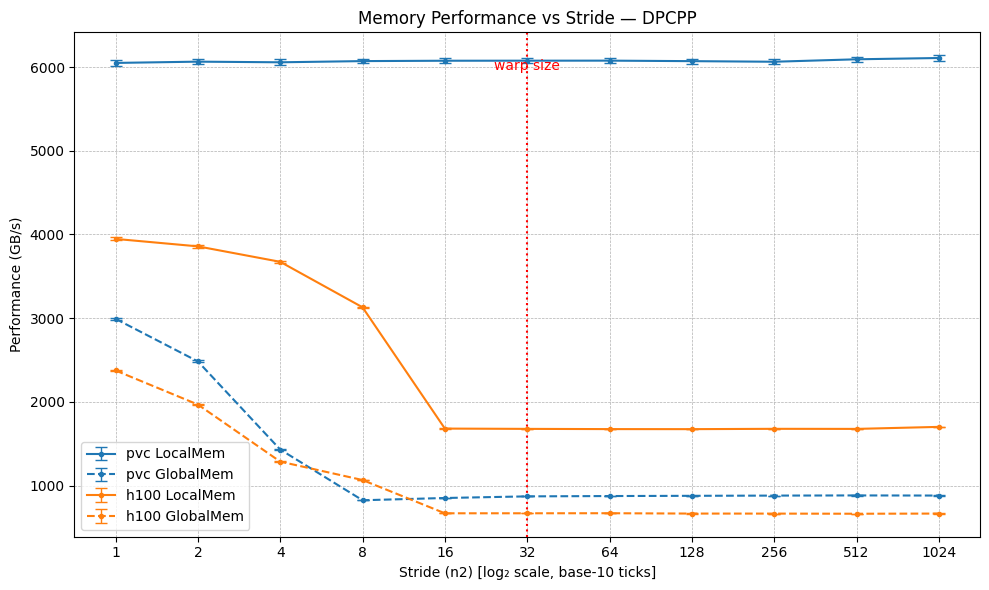

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

# Configuration
folder = "memory-spaces/"
compiler = "dpcpp"
file_pattern = f"{folder}/{compiler}_50_reps_*.json"

# Get all matching files
json_files = glob.glob(file_pattern)

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# Color map for different hardware
colors = plt.cm.tab10.colors  # 10 distinct colors
color_map = {}

# Process each file
for i, filepath in enumerate(json_files):
    hardware = os.path.splitext(os.path.basename(filepath))[0].split("_")[-1]
    color = colors[i % len(colors)]
    color_map[hardware] = color

    with open(filepath) as f:
        data = json.load(f)

    df = pd.DataFrame(data["benchmarks"])
    means = df[df["aggregate_name"] == "mean"].copy()
    stddevs = df[df["aggregate_name"] == "stddev"].copy()

    merge_keys = ["run_name", "per_family_instance_index"]
    merged = pd.merge(
        means,
        stddevs[merge_keys + ["bytes_per_second"]],
        on=merge_keys,
        suffixes=("", "_stddev")
    )

    merged["mem_type"] = merged["name"].apply(lambda x: "LocalMem" if "LocalMem" in x else "GlobalMem")
    merged["stride"] = merged["n2"]
    merged["GBps"] = merged["bytes_per_second"] / 1e9
    merged["GBps_stddev"] = merged["bytes_per_second_stddev"] / 1e9

    for mem_type, style in [("LocalMem", "-"), ("GlobalMem", "--")]:
        subset = merged[merged["mem_type"] == mem_type].sort_values("stride")
        label = f"{hardware} {mem_type}"

        ax.errorbar(
            subset["stride"],
            subset["GBps"],
            yerr=subset["GBps_stddev"],
            capsize=4,
            elinewidth=1,
            label=label,
            linestyle=style,
            marker='.',
            color=color
        )

# Log scale with base-10 ticks
ax.set_xscale("log", base=2)
xticks = sorted(set(merged["stride"]))
ax.set_xticks(xticks)
ax.set_xticklabels([str(int(x)) for x in xticks])

# Red vertical line for warp size
ax.axvline(x=32, color='red', linestyle=':', linewidth=1.5)
ax.text(32, ax.get_ylim()[1] * 0.95, 'warp size', color='red', ha='center', va='top', fontsize=10)

# Labels and style
ax.set_xlabel("Stride (n2) [log₂ scale, base-10 ticks]")
ax.set_ylabel("Performance (GB/s)")
ax.set_title("Memory Performance vs Stride — DPCPP")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()
plt.tight_layout()
plt.show()


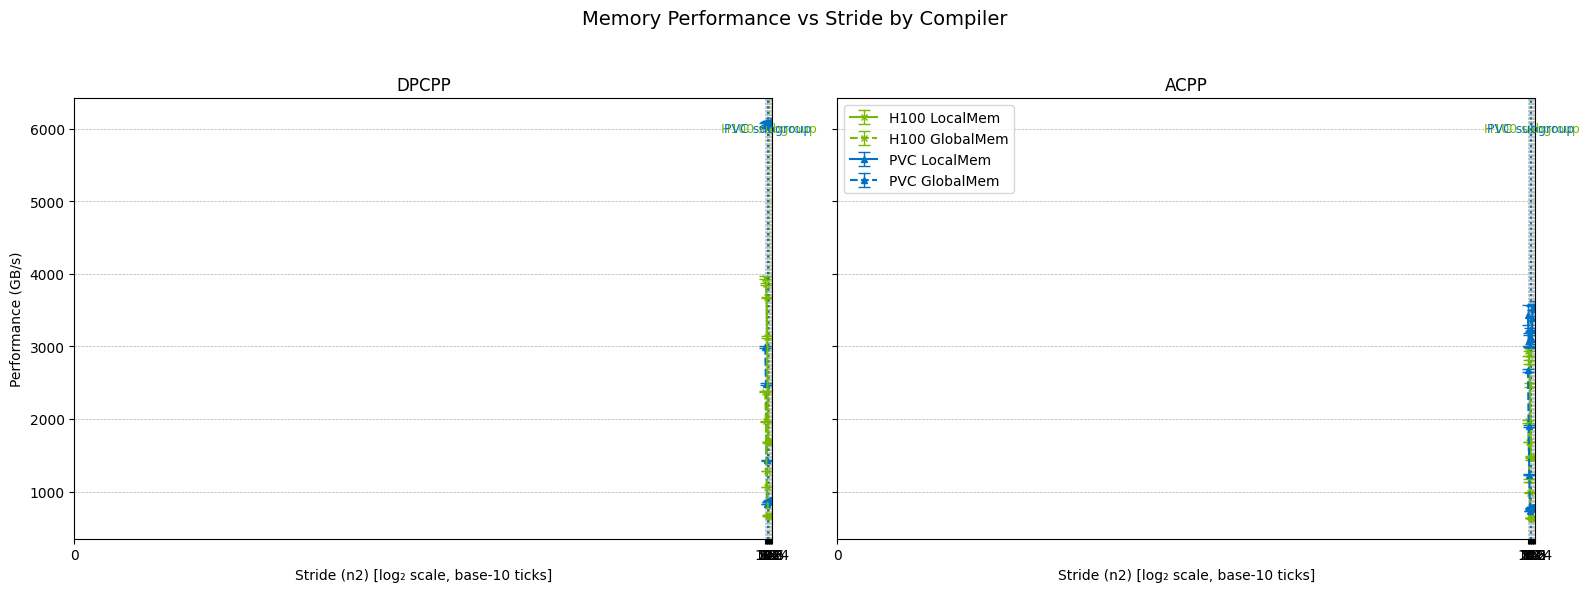

/tmp/ipykernel_124691/761651737.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(int(x)) for x in all_strides])
/tmp/ipykernel_124691/761651737.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(int(x)) for x in all_strides])


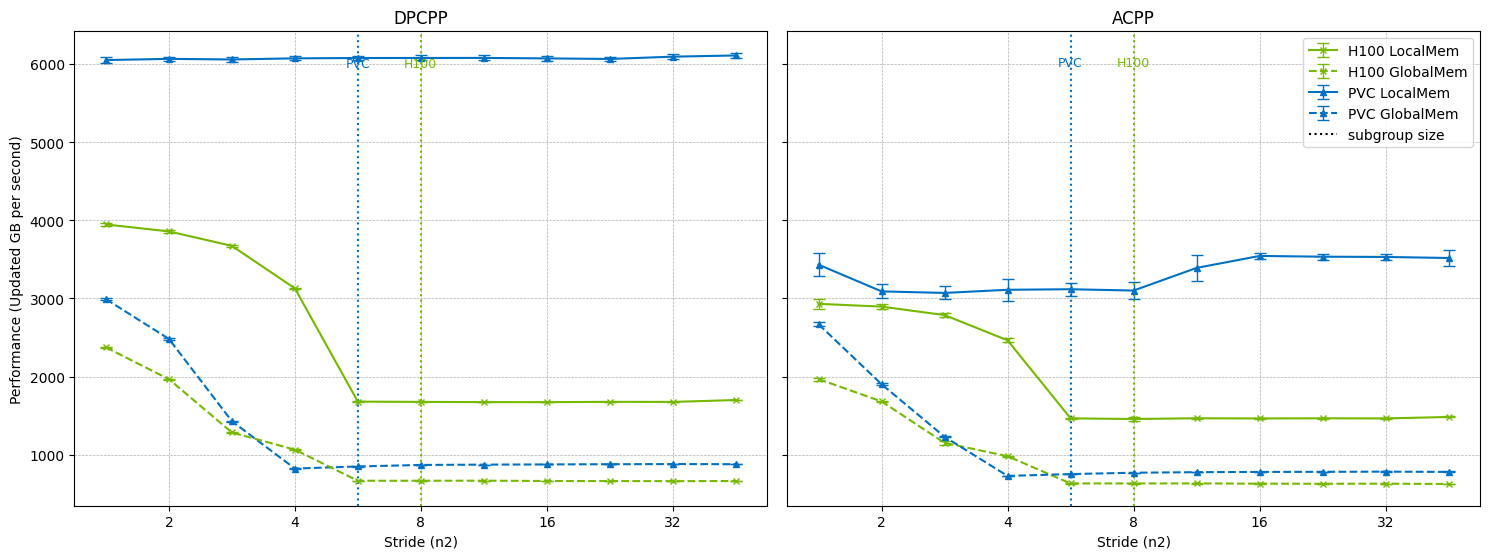

In [44]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.lines import Line2D
import os

# Configuration
folder = "memory-spaces/"
compilers = ["dpcpp", "acpp"]

hardware_colors = {
    "h100": "#76B900",  # NVIDIA green
    "pvc": "#0071C5",   # Intel blue
    # Add more hardware colors here as needed
}

subgroup_sizes = {
    "h100": 32,   # NVIDIA warp
    "pvc": 16,    # Intel subgroup
    # Add more subgroup sizes here
}

hardware_markers = {
    "h100": 'x',  # small cross
    "pvc": '^',   # triangle up
    # Add more markers here as needed
}

# Set up subplots: one per compiler
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for ax, compiler in zip(axes, compilers):
    file_pattern = f"{folder}/{compiler}_50_reps_*.json"
    json_files = glob.glob(file_pattern)

    all_strides = set()  # Collect all strides for proper x-axis ticks

    for filepath in json_files:
        hardware = os.path.splitext(os.path.basename(filepath))[0].split("_")[-1].lower()
        color = hardware_colors.get(hardware, 'gray')

        with open(filepath) as f:
            data = json.load(f)

        df = pd.DataFrame(data["benchmarks"])
        all_strides.update(df["n2"].unique())  # Collect strides

        means = df[df["aggregate_name"] == "mean"].copy()
        stddevs = df[df["aggregate_name"] == "stddev"].copy()

        merge_keys = ["run_name", "per_family_instance_index"]
        merged = pd.merge(
            means,
            stddevs[merge_keys + ["bytes_per_second"]],
            on=merge_keys,
            suffixes=("", "_stddev")
        )

        merged["mem_type"] = merged["name"].apply(lambda x: "LocalMem" if "LocalMem" in x else "GlobalMem")
        merged["stride"] = merged["n2"]
        merged["GBps"] = merged["bytes_per_second"] / 1e9
        merged["GBps_stddev"] = merged["bytes_per_second_stddev"] / 1e9

        for mem_type, style in [("LocalMem", "-"), ("GlobalMem", "--")]:
            subset = merged[merged["mem_type"] == mem_type].sort_values("stride")
            label = f"{hardware.upper()} {mem_type}"

            ax.errorbar(
                subset["stride"],
                subset["GBps"],
                yerr=subset["GBps_stddev"],
                capsize=4,
                elinewidth=1,
                label=label,
                linestyle=style,
                marker=hardware_markers.get(hardware, '.'),
                markersize=5,
                color=color
            )

    # Set log2 scale and base-10 stride labels
    all_strides = sorted(all_strides)
    ax.set_xscale("log", base=2)
    # ax.set_xticks(all_strides)
    ax.set_xticklabels([str(int(x)) for x in all_strides])
    ax.set_xlabel("Stride (n2)")
    ax.set_title(f"{compiler.upper()}")

    # Add subgroup size marker lines
    for hw, size in subgroup_sizes.items():
        if hw in hardware_colors:
            ax.axvline(x=size, color=hardware_colors[hw], linestyle=":", linewidth=1.5)
            ax.text(
                size, ax.get_ylim()[1] * 0.95,
                f"{hw.upper()}",
                color=hardware_colors[hw],
                ha="center", va="top", fontsize=9
            )

    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Custom legend line for subgroup size marker
subgroup_legend = Line2D(
    [0], [0],
    color='black',
    linestyle=':',
    linewidth=1.5,
    label='subgroup size'
)
# Single legend on second subplot
axes[1].legend(handles=[*axes[1].get_legend_handles_labels()[0], subgroup_legend], loc="best")
# Shared Y label
axes[0].set_ylabel("Performance (Updated GB per second)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("memory-spaces.pdf")
plt.show()
